### 1. Import libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
from scipy.special import expit, logit
from scipy.stats import norm, chi2
import scipy.stats as stats
import json

### 2. Load data set

In [14]:
df = pd.read_json('/mnt/d/PYDataScience/HIV_TXP_SR/data/supp.json')
# Print the shape of the DataFrame
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Print the column names
print(df.columns)

Number of rows: 48
Number of columns: 146
Index(['study_id', 'author', 'year_of_publication', 'country_of_study',
       'study_type', 'sample_size_(hiv_seropositive_only)', 'intervention',
       'outcome', 'conclusion', 'hiv_negative_samples',
       ...
       'cochrane_rob_missing_outcome_data_is_it_likely_that_missingness_in_the_outcome_depended_on_its_true_value?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_was_the_method_of_measuring_the_outcome_inappropriate?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_could_measurement_or_ascertainment_of_the_outcome_have_differed_between_intervention_groups?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_were_outcome_assessors_aware_of_the_intervention_received_by_study_participants?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_could_assessment_of_the_outcome_have_been_influenced_by_knowledge_of_intervention_received?',
       'cochrane_rob_risk_of_bias_in_meas

### 3. Publication bias with funnel plot, Egger's test and Begg's Rank correlation test

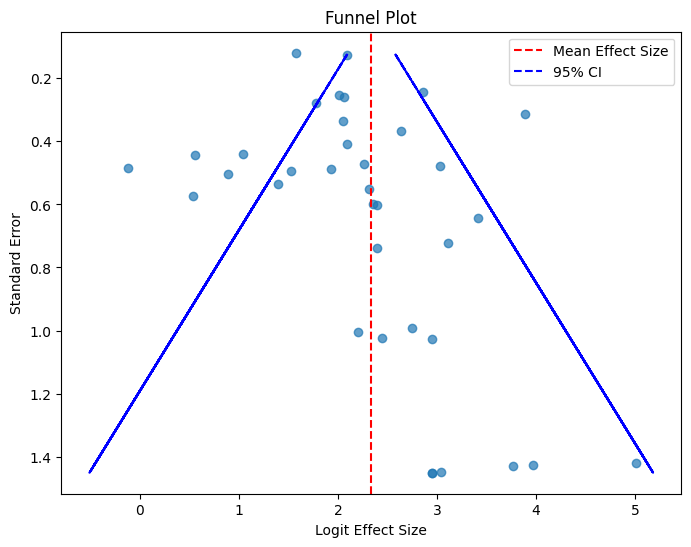

Egger's Regression Test Results:
{'slope': 1.3678245087387324, 'intercept': 1.4186256379630509, 'r_value': 0.546830896992919, 'p_value': 0.0005587808962861658, 'std_err': 0.35916122384955573}
Begg's Rank Correlation Test Results:
{'slope': 1.2590939773531762, 'intercept': 14.558718291284496, 'r_value': 0.12426417776729533, 'p_value': 0.4702464706146271, 'std_err': 1.7242231887847552}


In [15]:
# Creating a copy of the relevant columns
survival_data = df[["study_id", "1-year_patient_survival_(%)_hiv+", "3-year_patient_survival_(%)_hiv+", ">=_5-year_patient_survival_(%)_hiv+"]].copy()

# Replacing "None" with NaN and ensuring the data is numeric
survival_data.replace("None", np.nan, inplace=True)
survival_data.iloc[:, 1:] = survival_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Initialize an empty list for effect sizes
effect_size = np.full(len(survival_data), np.nan)

# Apply selection criteria
for i in range(len(survival_data)):
    if not pd.isna(survival_data.iloc[i, 3]):
        effect_size[i] = survival_data.iloc[i, 3]
    elif not pd.isna(survival_data.iloc[i, 2]):
        effect_size[i] = survival_data.iloc[i, 2]
    elif not pd.isna(survival_data.iloc[i, 1]):
        effect_size[i] = survival_data.iloc[i, 1]

effect_size = effect_size / 100
sample_size = df['sample_size_(hiv_seropositive_only)'].to_numpy()

# Adjust effect sizes slightly to avoid 0% and 100%
effect_size = np.clip(effect_size, 1 / (2 * sample_size), 1 - 1 / (2 * sample_size))

# Apply logit transformation
logit_effect_size = np.log(effect_size / (1 - effect_size))

# Calculate standard error after logit transformation
se_logit = np.sqrt(1 / (sample_size * effect_size) + 1 / (sample_size * (1 - effect_size)))

# Remove NaN values from both logit_effect_size and se_logit
mask = ~np.isnan(logit_effect_size) & ~np.isnan(se_logit)
logit_effect_size_filtered = logit_effect_size[mask]
se_logit_filtered = se_logit[mask]

# Funnel plot
# Calculating the overall mean effect size
mean_effect_size = np.mean(logit_effect_size_filtered)

# Create the funnel plot
plt.figure(figsize=(8, 6))
plt.scatter(logit_effect_size_filtered, se_logit_filtered, alpha=0.7)

# Adding the vertical line for the mean effect size
plt.axvline(mean_effect_size, color='red', linestyle='--', label='Mean Effect Size')

# Adding the diagonal lines representing 95% CI
upper_ci = mean_effect_size + 1.96 * se_logit_filtered
lower_ci = mean_effect_size - 1.96 * se_logit_filtered
plt.plot(mean_effect_size + se_logit_filtered * 1.96, se_logit_filtered, color='blue', linestyle='--', label='95% CI')
plt.plot(mean_effect_size - se_logit_filtered * 1.96, se_logit_filtered, color='blue', linestyle='--')

# Inverting the y-axis
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Logit Effect Size')
plt.ylabel('Standard Error')
plt.title('Funnel Plot')
plt.legend()

# Show the plot
plt.savefig('/mnt/d/pydatascience/hiv_txp_sr/publication_bias_funnel_1000.png', dpi=1000)
plt.show()

# Egger's Regression Test (using linregress)
slope, intercept, r_value, p_value, std_err = linregress(se_logit_filtered, logit_effect_size_filtered)
egger_test = {
    "slope": slope,
    "intercept": intercept,
    "r_value": r_value,
    "p_value": p_value,
    "std_err": std_err
}
print("Egger's Regression Test Results:")
print(egger_test)

# Begg's Rank Correlation Test (approximation using Spearman correlation)
begg_slope, begg_intercept, begg_r_value, begg_p_value, begg_std_err = linregress(logit_effect_size_filtered, np.arange(len(logit_effect_size_filtered)))
begg_test = {
    "slope": begg_slope,
    "intercept": begg_intercept,
    "r_value": begg_r_value,
    "p_value": begg_p_value,
    "std_err": begg_std_err
}
print("Begg's Rank Correlation Test Results:")
print(begg_test)

### 4. Meta-analysis of primary and secondary outcome

In [293]:
# Function to convert logit to proportion
def logit_to_proportion(logit_value):
    return expit(logit_value)  # expit is the inverse of logit

# Function to perform meta-analysis
def perform_meta_analysis(valid_data):
    # Avoid proportions of 0 and 1 by adding a small constant
    epsilon = 0.5 / np.min(valid_data['sample_size'])
    valid_data['proportion'] = np.clip(valid_data['proportion'], epsilon, 1 - epsilon)
    # Logit transformation of proportions
    valid_data['z'] = logit(valid_data['proportion'])
    
    # Variance of logit-transformed proportions
    valid_data['var_z'] = 1 / (np.array(valid_data['sample_size']) * valid_data['proportion'] * (1 - valid_data['proportion']))
    
    w = 1 / np.array(valid_data['var_z'])
    z_bar = np.sum(w * valid_data['z']) / np.sum(w)
    k = len(valid_data['z'])  
    Q = np.sum(w * (valid_data['z'] - z_bar)**2)
    
    # Calculating p-value for Q
    p_value_Q = 1 - stats.chi2.cdf(Q, k - 1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_z']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['z']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)
    
    # Calculate overall effect Z-value and p-value
    Z_value = z_bar_RE / se_z_bar_RE
    p_value_Z = 2 * (1 - norm.cdf(np.abs(Z_value)))

    # Back Transformation to proportion scale
    proportion_bar_RE = expit(z_bar_RE)
    ci_proportion_bar_RE = (expit(ci_z_bar_RE[0]), expit(ci_z_bar_RE[1]))

    # Prepare DataFrame with study-specific results
    valid_data['effect_size'] = expit(valid_data['z'])
    valid_data['ci_lb'] = expit(valid_data['z'] - 1.96 * np.sqrt(valid_data['var_z']))
    valid_data['ci_ub'] = expit(valid_data['z'] + 1.96 * np.sqrt(valid_data['var_z']))
    valid_data['weight_percent'] = weights_percent

    # Create a DataFrame for the pooled result
    pooled_result = pd.DataFrame({
        'study_id': ['Pooled Estimate'],
        'sample_size': [np.sum(valid_data['sample_size'])],
        'effect_size': [proportion_bar_RE],
        'ci_lb': [ci_proportion_bar_RE[0]],
        'ci_ub': [ci_proportion_bar_RE[1]],
        'weight_percent': [np.sum(weights_percent)]
    })

    # Combine individual study results with the pooled result
    combined_results = pd.concat([valid_data[['study_id', 'sample_size', 'effect_size', 'ci_lb', 'ci_ub', 'weight_percent']], pooled_result])

    return proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z

# Select and rename columns
pt_survival_df = df[['sample_size_(hiv_seropositive_only)', 'study_id', 
                     '1-year_infection_incidence(100_pt-yr)_hiv+', 
                     '3-year_infection_incidence(100_pt-yr)_hiv+', 
                     '>=_5-year_infection_incidence(100_pt-yr)_hiv+']].copy()
pt_survival_df.columns = ['sample_size', 'study_id', '1_yr', '3_yr', '5_yr']

# Prepare data for 1-year survival meta-analysis
pt_survival_df['proportion'] = pt_survival_df['3_yr'] / 100
valid_data = pt_survival_df[['study_id', 'sample_size', 'proportion']].dropna()

# Perform the meta-analysis
proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data)

# Display the results
print(f"Pooled 5-Year Survival Proportion: {proportion_bar_RE:.4f}")
print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
print(f"I²: {I2:.2f}%")
print(f"Q: {Q:.2f}")
print(f"p-value for Q: {p_value_Q:.4f}")
print(f"tau2: {tau2:.4f}")
print(f"Z: {Z_value:.2f}")
print(f"p-value for Z: {p_value_Z:.4f}")
# Display the combined results for each study and the pooled result
print(combined_results)

combined_results_dict = combined_results.to_dict(orient='records')
summary_results = {
    "Pooled_Survival_Proportion": proportion_bar_RE,
    "95%_CI": ci_proportion_bar_RE,
    "I2": I2,
    "Q": Q,
    "p_value_for_Q": p_value_Q,
    "tau2": tau2,
    "Z": Z_value,
    "p_value_for_Z": p_value_Z,
    "combined_results": combined_results_dict
}

summary_json_file_path = '/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_infection.json'  # Specify your desired path and filename here
with open(summary_json_file_path, 'w') as f:
    json.dump(summary_results, f, indent=4)

Pooled 5-Year Survival Proportion: 0.0758
95% CI: (0.0166, 0.2845)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Z: -3.10
p-value for Z: 0.0019
          study_id  sample_size  effect_size     ci_lb     ci_ub  \
8      Camargo2019           22       0.0758  0.016632  0.284544   
0  Pooled Estimate           22       0.0758  0.016632  0.284544   

   weight_percent  
8           100.0  
0           100.0  


#### Meta-analysis of the primary and secondary outcomes between HIV positive and negative patient groups post-renal transplantation:

In [230]:
def perform_meta_analysis(valid_data):
    # Calculate log hazard ratios
    valid_data['log_hazard_ratio'] = np.log(valid_data['hazard_ratio'])
    
    # Variance of log hazard ratios
    valid_data['var_log_hazard_ratio'] = 1 / valid_data['sample_size']
    
    # Weights based on inverse variance
    w = 1 / np.array(valid_data['var_log_hazard_ratio'])
    z_bar = np.sum(w * valid_data['log_hazard_ratio']) / np.sum(w)
    k = len(valid_data['log_hazard_ratio'])
    Q = np.sum(w * (valid_data['log_hazard_ratio'] - z_bar)**2)
    
    # Calculating p-value for Q
    p_value_Q = 1 - chi2.cdf(Q, k - 1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_log_hazard_ratio']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['log_hazard_ratio']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)

    # Back Transformation to hazard ratio scale
    hazard_ratio_bar_RE = np.exp(z_bar_RE)
    ci_hazard_ratio_bar_RE = (np.exp(ci_z_bar_RE[0]), np.exp(ci_z_bar_RE[1]))

    # Prepare DataFrame with study-specific results
    valid_data['effect_size'] = np.exp(valid_data['log_hazard_ratio'])
    valid_data['ci_lb'] = np.exp(valid_data['log_hazard_ratio'] - 1.96 * np.sqrt(valid_data['var_log_hazard_ratio']))
    valid_data['ci_ub'] = np.exp(valid_data['log_hazard_ratio'] + 1.96 * np.sqrt(valid_data['var_log_hazard_ratio']))
    valid_data['weight_percent'] = weights_percent

    # Create a DataFrame for the pooled result
    pooled_result = pd.DataFrame({
        'study_id': ['Pooled Estimate'],
        'sample_size': [np.sum(valid_data['sample_size'])],
        'effect_size': [hazard_ratio_bar_RE],
        'ci_lb': [ci_hazard_ratio_bar_RE[0]],
        'ci_ub': [ci_hazard_ratio_bar_RE[1]],
        'weight_percent': [np.sum(weights_percent)]
    })

    # Combine individual study results with the pooled result
    combined_results = pd.concat([valid_data[['study_id', 'sample_size', 'effect_size', 'ci_lb', 'ci_ub', 'weight_percent']], pooled_result])

    return hazard_ratio_bar_RE, ci_hazard_ratio_bar_RE, combined_results, I2, Q, p_value_Q, tau2

def calculate_hazard_ratios(df, sample_size_col, study_id_col, group1_col, group2_col):
    # Select and filter the required columns
    selected_df = df[[study_id_col, sample_size_col, group1_col, group2_col]].dropna()
    
    # Convert survival probabilities from percentage to proportion
    selected_df[f'{group1_col}_prop'] = selected_df[group1_col] / 100
    selected_df[f'{group2_col}_prop'] = selected_df[group2_col] / 100

    # Convert survival probabilities to hazard rates
    selected_df[f'{group1_col}_hazard'] = -np.log(selected_df[f'{group1_col}_prop'])
    selected_df[f'{group2_col}_hazard'] = -np.log(selected_df[f'{group2_col}_prop'])

    # Avoid hazard rates of 0
    epsilon = 0.5 / np.min(selected_df[sample_size_col])
    selected_df[f'{group1_col}_hazard'] = np.where(selected_df[f'{group1_col}_hazard'] == 0, epsilon, selected_df[f'{group1_col}_hazard'])
    selected_df[f'{group2_col}_hazard'] = np.where(selected_df[f'{group2_col}_hazard'] == 0, epsilon, selected_df[f'{group2_col}_hazard'])

    # Calculate hazard ratios (HR)
    selected_df['hazard_ratio'] = selected_df[f'{group1_col}_hazard'] / selected_df[f'{group2_col}_hazard']
    
    return selected_df

# Load and prepare the data
pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

# Select and filter data for 1-year survival
result_df = calculate_hazard_ratios(rj_survival_hr_df, 'sample_size', 'study_id', '5_yr_pos', '5_yr_neg')
proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2 = perform_meta_analysis(result_df)

# Display the results
print(f"Pooled 1-Year Survival Proportion: {proportion_bar_RE:.4f}")
print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
print(f"I²: {I2:.2f}%")
print(f"Q: {Q:.2f}")
print(f"p-value for Q: {p_value_Q:.4f}")
print(f"tau2: {tau2:.4f}")
# Display the combined results for each study and the pooled result
print(combined_results)

combined_results_dict = combined_results.to_dict(orient='records')
summary_results = {
    "Pooled_Survival_Proportion": proportion_bar_RE,
    "95%_CI": ci_proportion_bar_RE,
    "I2": I2,
    "Q": Q,
    "p_value_for_Q": p_value_Q,
    "tau2": tau2,
    "combined_results": combined_results_dict
}

summary_json_file_path = '/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_hr.json'  # Specify your desired path and filename here
with open(summary_json_file_path, 'w') as f:
    json.dump(summary_results, f, indent=4)

Pooled 1-Year Survival Proportion: 0.6222
95% CI: (0.4598, 0.8420)
I²: 82.75%
Q: 17.39
p-value for Q: 0.0006
tau2: 0.0738
           study_id  sample_size  effect_size     ci_lb     ci_ub  \
4      Apewokin2018          605     0.820911  0.758035  0.889002   
28     Mazuecos2011           20     0.614278  0.396303  0.952145   
30     Mazuecos2013           36     0.443268  0.319740  0.614519   
45       Vicari2016           53     0.609019  0.465272  0.797176   
0   Pooled Estimate          714     0.622211  0.459790  0.842007   

    weight_percent  
4        31.582609  
28       19.246030  
30       23.457639  
45       25.713721  
0       100.000000  


### 5. Univariable Meta-regression for effects of different factors on primary and secondary outcomes

In [208]:
def perform_meta_regression(df, study_id_col, sample_size_col, effect_size_col, categorical_cols, continuous_cols, output_json='meta_regression_results.json'):
    results = []

    # Convert effect measure to proportion if it's in percentage
    moderators = [col for col in df.columns if col not in [study_id_col, sample_size_col, effect_size_col]]
    
    # Analyze each variable (categorical and continuous)
    for col in moderators:
        mod_data = df[[study_id_col, sample_size_col, effect_size_col, col]].dropna().copy()
        mod_data.loc[:, 'effect_measure'] = mod_data[effect_size_col].copy() / 100
        epsilon = 0.5 / mod_data[sample_size_col].min()
        mod_data['effect_measure'] = np.clip(mod_data['effect_measure'], epsilon, 1 - epsilon)
        mod_data['logit_effect_measure'] = logit(mod_data['effect_measure'])

        # Calculate variance
        mod_data['var_logit_effect_measure'] = (
            1 / (mod_data[sample_size_col] * mod_data['effect_measure']) + 
            1 / (mod_data[sample_size_col] * (1 - mod_data['effect_measure']))
        )
        mod_data['weight'] = 1 / mod_data['var_logit_effect_measure']
        
        # Handle categorical variables
        if categorical_cols and col in categorical_cols:
            mod_data[col] = mod_data[col].astype('int')
        
        # Define your independent (X) and dependent (Y) variables
        X = mod_data[[col]]
        Y = mod_data['logit_effect_measure']
        weights = 1 / mod_data['var_logit_effect_measure']

        # Add a constant to the independent variable (for intercept)
        X = sm.add_constant(X)

        # Fit the fixed effects model
        try:
            if np.linalg.matrix_rank(X) < X.shape[1]:
                print(f"Multicollinearity detected in {col}. Skipping...")
                continue
            if len(mod_data) >= 2:
                print(f"Independent variable: {col}")
                print(f"Studies involved: {len(mod_data)}")
                fixed_effect_model = sm.WLS(Y, X, weights=weights).fit()
                fixed_effect_coefs = fixed_effect_model.params
                fixed_effect_se = fixed_effect_model.bse
                fixed_effect_ci_lower = fixed_effect_coefs - 1.96 * fixed_effect_se
                fixed_effect_ci_upper = fixed_effect_coefs + 1.96 * fixed_effect_se
                print(fixed_effect_model.summary())
                # Fit the random effects model
                random_effect_model = MixedLM(Y, X, groups=mod_data[study_id_col]).fit()
                random_effect_coefs = random_effect_model.params
                random_effect_se = random_effect_model.bse
                random_effect_ci_lower = random_effect_coefs - 1.96 * random_effect_se
                random_effect_ci_upper = random_effect_coefs + 1.96 * random_effect_se
                print(random_effect_model.summary())
                # Store results
                
                studies_details = []
                for i, study in mod_data.iterrows():
                    studies_details.append({
                        'study_id': study[study_id_col],
                        'fixed_effect': {
                            'coef': fixed_effect_coefs.loc[col],
                            'weight': weights[i],
                            'ci_lower': fixed_effect_ci_lower.loc[col],
                            'ci_upper': fixed_effect_ci_upper.loc[col],
                        },
                        'random_effect': {
                            'coef': random_effect_coefs.loc[col],
                            'weight': weights[i],
                            'ci_lower': random_effect_ci_lower.loc[col],
                            'ci_upper': random_effect_ci_upper.loc[col],
                        }
                    })
                results.append({
                    'variable': col,
                    'studies involved': mod_data[study_id_col].values.tolist(),
                    'studies_details': studies_details,
                    'fixed_effects': {
                        'coef': fixed_effect_model.params.tolist(),
                        'pvalues': fixed_effect_model.pvalues.tolist(),
                        'rsquared': fixed_effect_model.rsquared,
                        'aic': fixed_effect_model.aic,
                        'bic': fixed_effect_model.bic
                    },
                    'random_effects': {
                        'coef': random_effect_model.params.tolist(),
                        'pvalues': random_effect_model.pvalues.tolist(),
                        'group_variance': random_effect_model.cov_re.iloc[0, 0],
                        'log_likelihood': random_effect_model.llf
                    }
                })
        except np.linalg.LinAlgError as e:
            print(f"Linear algebra error in {col}: {e}")
        except Exception as e:
            print(f"Unexpected error in {col}: {e}")
            # Convert results to DataFrame and save to JSON
    results_df = pd.DataFrame(results)
    results_df.to_json(output_json, orient='records', indent=4)

    return results_df


ps_df_1 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    "1-year_patient_survival_(%)_hiv+", "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

ps_df_1.columns = [
    'sample_size', 'study_id', '1_yr_ps', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
ps_df_1['ii_shift'] = ps_df_1.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

ps_df_1['pi_avoid'] = ps_df_1.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

ps_df_1['viral_breakthrough'] = ps_df_1.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)
# Define categorical and continuous variables
categorical_cols = ['ii_shift', 'pi_avoid', 'viral_breakthrough']
continuous_cols = ['hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 
    'cd52', 
    'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post']

result_df = perform_meta_regression(ps_df_1, 'study_id', 'sample_size', '1_yr_ps', categorical_cols, continuous_cols, 
                                    output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_pt_survival_subgp.json')
print(result_df)

/tmp/ipykernel_17100/3463950038.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_1['ii_shift'] = ps_df_1.apply(
/tmp/ipykernel_17100/3463950038.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_1['pi_avoid'] = ps_df_1.apply(
/tmp/ipykernel_17100/3463950038.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Independent variable: hivan
Studies involved: 15
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.092
Model:                              WLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     1.321
Date:                  Tue, 03 Sep 2024   Prob (F-statistic):              0.271
Time:                          07:00:26   Log-Likelihood:                -10.004
No. Observations:                    15   AIC:                             24.01
Df Residuals:                        13   BIC:                             25.42
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  re

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logit_effect_measure
No. Observations: 6       Method:             REML                
No. Groups:       6       Scale:              0.1355              
Min. group size:  1       Log-Likelihood:     -3.8239             
Max. group size:  1       Converged:          Yes                 
Mean group size:  1.0                                             
---------------------------------------------------------------------
             Coef.    Std.Err.      z       P>|z|    [0.025    0.975]
---------------------------------------------------------------------
const        2.975       0.032    92.688    0.000     2.912     3.038
cd52         0.245       0.474     0.516    0.606    -0.684     1.174
Group Var    0.136                                                   

Independent variable: induction_use
Studies involved: 17
                             WLS Regression Results                 

/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


### 6. Univariable Meta-regression for effects of different factors on the hazard ratio of primary and secondary outcomes

In [217]:
# Load and prepare the data
pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

# Select and filter data for 1-year survival
result_df = calculate_hazard_ratios(rj_survival_hr_df, 'sample_size', 'study_id', '5_yr_pos', '5_yr_neg')
selected_columns_df = df[['study_id', "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]
selected_columns_df.columns = [
    'study_id', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]
merged_df = pd.merge(result_df, selected_columns_df, on='study_id', how='inner')

merged_df['ii_shift'] = merged_df.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

merged_df['pi_avoid'] = merged_df.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

merged_df['viral_breakthrough'] = merged_df.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)
categorical_cols = ['ii_shift', 'pi_avoid', 'viral_breakthrough']
continuous_cols = ['hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 
    'cd52', 
    'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post']

merged_df = merged_df[['sample_size', 'study_id', 'hazard_ratio'] + categorical_cols + continuous_cols].copy()

result_df = perform_meta_regression(merged_df, 'study_id', 'sample_size', 'hazard_ratio', categorical_cols, continuous_cols, 
                                    output_json='/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_hr_subgp.json')
print(result_df)

Unexpected error in ii_shift: zero-size array to reduction operation maximum which has no identity
Multicollinearity detected in pi_avoid. Skipping...
Multicollinearity detected in viral_breakthrough. Skipping...
Independent variable: hcv
Studies involved: 3
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                      -0.882
Model:                              WLS   Adj. R-squared:                 -2.764
Method:                   Least Squares   F-statistic:                   -0.4686
Date:                  Tue, 03 Sep 2024   Prob (F-statistic):               1.00
Time:                          07:07:16   Log-Likelihood:                 100.73
No. Observations:                     3   AIC:                            -197.5
Df Residuals:                         1   BIC:                            -199.3
Df Model:                             1                                         
Covariance T

/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/home/goma/m

### 7. Multivariate Meta-regression for effects of different factors on primary and secondary outcomes and hazard ratio:
#### Get significant factors affecting the outcomes first:

In [272]:
# Load the JSON files
files = [
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_rejection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_infection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_pt_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_gf_rejection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_gf_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_infection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_pt_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_infection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_pt_survival_subgp.json"
]

factors_data = []

for file in files:
    filename = file.split('/')[-1]
    with open(file, 'r') as f:
        data = json.load(f)
        for item in data:
            variable = item.get('variable')
            random_effects = item.get('random_effects', {})
            for coef, pvalue in zip(random_effects.get('coef', []), random_effects.get('pvalues', [])):
                factors_data.append({
                    "Factor": variable,
                    "Effect Type": "Random",
                    "Coefficient": coef,
                    "P-Value": pvalue,
                    "File Source": filename
                })

# Create a DataFrame from the extracted data
factors_df = pd.DataFrame(factors_data)
factors_df = factors_df.groupby(['Factor', 'File Source']).apply(lambda x: x.iloc[1]).reset_index(drop=True)
factors_df = factors_df.loc[(factors_df['P-Value'] < 0.05) & (factors_df['P-Value'] > 0), :]
pivot_factors = factors_df.pivot_table(
    columns='Factor',
    index='File Source',
    values='Coefficient',
    aggfunc='min'  # Use the minimum p-value if multiple exist
)
factors_with_values = pivot_factors.apply(lambda row: row.dropna().index.tolist(), axis=1)

# Dictionary to hold the number of studies for each factor and file source
study_counts = {}

# Iterate through the JSON files and count studies
for file in files:
    filename = file.split('/')[-1]
    with open(file, 'r') as f:
        data = json.load(f)
        for item in data:
            factor = item.get('variable')
            studies = len(item.get('studies_details', []))
            study_counts[(filename, factor)] = studies

# Create a DataFrame to show the number of studies for each factor in each file source
study_counts_df = pd.DataFrame.from_dict(study_counts, orient='index', columns=['Number of Studies'])

# Reset the index to separate the File Source and Factor columns
study_counts_df = study_counts_df.reset_index()
# The 'index' column will contain tuples, so we'll split them
study_counts_df[['File Source', 'Factor']] = pd.DataFrame(study_counts_df['index'].tolist(), index=study_counts_df.index)

# Match this DataFrame with the factors_with_values Series
matched_study_counts = []

for file_source, factors in factors_with_values.items():
    for factor in factors:
        count = study_counts_df.loc[(study_counts_df['File Source'] == file_source) & (study_counts_df['Factor'] == factor), 'Number of Studies'].values
        if len(count) > 0:
            matched_study_counts.append({
                "File Source": file_source,
                "Factor": factor,
                "Number of Studies": count[0]
            })

# Convert the matched study counts to a DataFrame
matched_study_counts_df = pd.DataFrame(matched_study_counts)
sig_factor_df = pd.merge(matched_study_counts_df, factors_df[['Factor', 'Coefficient', 'P-Value', 'File Source']], on=['File Source', 'Factor'], how='inner')
sig_factor_df = sig_factor_df[sig_factor_df['Number of Studies']>9]


|    | File Source                  | Factor                                                                                                                             |
|---:|:-----------------------------|:-----------------------------------------------------------------------------------------------------------------------------------|
|  0 | 1_yr_gf_rejection_subgp.json | ['hivan', 'il_2', 'induction_use', 'nnrti_post', 'nnrti_pre', 'pi_avoid', 'pi_pre', 'viral_breakthrough']                          |
|  1 | 1_yr_gf_survival_subgp.json  | ['hbv', 'hcv', 'ii_post', 'nnrti_post', 'nnrti_pre', 'pi_avoid', 'pi_post', 'pi_pre', 'viral_suppress_post', 'viral_suppress_pre'] |
|  2 | 1_yr_pt_survival_subgp.json  | ['atg', 'cd4', 'nnrti_post', 'pi_avoid', 'pi_post', 'pi_pre']                                                                      |
|  3 | 3_yr_gf_survival_subgp.json  | ['hbv', 'pi_avoid', 'pi_post']                                                                                                     |
|  4 | 3_yr_pt_survival_subgp.json  | ['induction_use', 'viral_suppress_pre']                                                                                            |
|  5 | 5_yr_gf_survival_subgp.json  | ['hcv']                                                                                                                            |


In [290]:

def perform_multivariate_meta_regression(df, study_id_col, sample_size_col, effect_size_col, categorical_cols, continuous_cols, output_json='meta_regression_results.json'):
    results = []

    # Select all moderators (categorical and continuous)
    moderators = categorical_cols + continuous_cols
    
    # Prepare the dataset with selected moderators
    mod_data = df[[study_id_col, sample_size_col, effect_size_col] + moderators].dropna().copy()
    
    # Convert effect size to proportion if it's in percentage
    mod_data.loc[:, 'effect_measure'] = mod_data[effect_size_col].copy() / 100
    epsilon = 0.5 / mod_data[sample_size_col].min()
    mod_data['effect_measure'] = np.clip(mod_data['effect_measure'], epsilon, 1 - epsilon)
    mod_data['logit_effect_measure'] = logit(mod_data['effect_measure'])

    # Calculate variance
    mod_data['var_logit_effect_measure'] = (
        1 / (mod_data[sample_size_col] * mod_data['effect_measure']) + 
        1 / (mod_data[sample_size_col] * (1 - mod_data['effect_measure']))
    )
    mod_data['weight'] = 1 / mod_data['var_logit_effect_measure']
    
    # Handle categorical variables
    if categorical_cols:
        for col in categorical_cols:
            mod_data[col] = mod_data[col].astype('int')
    print(mod_data)
    # Define the independent (X) and dependent (Y) variables
    X = mod_data[moderators]
    Y = mod_data['logit_effect_measure']
    weights = 1 / mod_data['var_logit_effect_measure']

    # Add a constant to the independent variables (for intercept)
    X = sm.add_constant(X)

    # Fit the fixed effects model
    try:
        if np.linalg.matrix_rank(X) < X.shape[1]:
            print(f"Multicollinearity detected. Skipping...")
        else:
            if len(mod_data) >= 2:
                print(f"Performing multivariate meta-regression...")
                fixed_effect_model = sm.WLS(Y, X, weights=weights).fit()
                fixed_effect_coefs = fixed_effect_model.params
                fixed_effect_se = fixed_effect_model.bse
                fixed_effect_ci_lower = fixed_effect_coefs - 1.96 * fixed_effect_se
                fixed_effect_ci_upper = fixed_effect_coefs + 1.96 * fixed_effect_se
                print(fixed_effect_model.summary())
                
                # Fit the random effects model
                random_effect_model = MixedLM(Y, X, groups=mod_data[study_id_col]).fit()
                random_effect_coefs = random_effect_model.params
                random_effect_se = random_effect_model.bse
                random_effect_ci_lower = random_effect_coefs - 1.96 * random_effect_se
                random_effect_ci_upper = random_effect_coefs + 1.96 * random_effect_se
                print(random_effect_model.summary())
                
                # Store the results
                results.append({
                    'studies_involved': mod_data[study_id_col].values.tolist(),
                    'fixed_effects': {
                        'coef': fixed_effect_model.params.tolist(),
                        'upper_ci': fixed_effect_ci_upper,
                        'lower_ci': fixed_effect_ci_lower,                        
                        'pvalues': fixed_effect_model.pvalues.tolist(),
                        'rsquared': fixed_effect_model.rsquared,
                        'aic': fixed_effect_model.aic,
                        'bic': fixed_effect_model.bic
                    },
                    'random_effects': {
                        'coef': random_effect_model.params.tolist(),
                        'upper_ci': random_effect_ci_upper,
                        'lower_ci': random_effect_ci_lower, 
                        'pvalues': random_effect_model.pvalues.tolist(),
                        'group_variance': random_effect_model.cov_re.iloc[0, 0],
                        'log_likelihood': random_effect_model.llf
                    }
                })
    except np.linalg.LinAlgError as e:
        print(f"Linear algebra error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    
    # Convert results to DataFrame and save to JSON
    results_df = pd.DataFrame(results)
    results_df.to_json(output_json, orient='records', indent=4)

    return results_df

# 1_yr_graft_rejection
categorical_cols = ['pi_avoid', 'viral_breakthrough']
continuous_cols = ['hivan', 'il_2', 'induction_use']

# Perform multivariate meta-regression
gf_rj_1_multi = perform_multivariate_meta_regression(gr_df_1, 'study_id', 'sample_size', '1_yr_gr', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_rejection_multi_regression.json')

# 1_yr_graft_survival
categorical_cols = ['pi_avoid']
continuous_cols = ['hbv', 'hcv', 'ii_post']
# Perform multivariate meta-regression
gf_sv_1_multi = perform_multivariate_meta_regression(gs_df_1, 'study_id', 'sample_size', '1_yr_gs', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_survival_multi_regression.json')

# 1_yr_pt_survival
categorical_cols = ['pi_avoid']
continuous_cols = ['atg', 'cd4'] 
pt_sv_1_multi = perform_multivariate_meta_regression(ps_df_1, 'study_id', 'sample_size', '1_yr_ps', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_pt_survival_multi_regression.json')

# 3_yr_gf_survival
categorical_cols = ['pi_avoid']
continuous_cols = ['hbv'] 
gf_sv_3_multi = perform_multivariate_meta_regression(gs_df_3, 'study_id', 'sample_size', '3_yr_gs', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_gf_survival_multi_regression.json')

# 3_yr_pt_survival
categorical_cols = []
continuous_cols = ['induction_use', 'viral_suppress_pre'] 
pt_sv_3_multi = perform_multivariate_meta_regression(ps_df_3, 'study_id', 'sample_size', '3_yr_ps', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_pt_survival_multi_regression.json')

# 5_yr_gf_survival
categorical_cols = []
continuous_cols = ['hcv'] 
gf_sv_5_multi = perform_multivariate_meta_regression(gs_df_5, 'study_id', 'sample_size', '5_yr_gs', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_survival_multi_regression.json')

          study_id  sample_size  1_yr_gr  pi_avoid  viral_breakthrough  \
2       Alfano2018           19    32.90         1                   0   
5         Azar2017           13    15.38         1                   0   
11      Durand2021           75    36.00         0                   1   
15     Gathogo2014           35    47.00         0                   1   
34  Muthukumar2013           11     9.00         0                   1   
36      Roland2008           18    52.00         0                   1   
42       Stock2010          150    31.00         0                   1   
44      Touzot2010           27    15.00         1                   1   

       hivan      il_2  induction_use  effect_measure  logit_effect_measure  \
2   0.105263  1.000000       1.000000          0.3290             -0.712711   
5   0.230769  0.384615       1.000000          0.1538             -1.705103   
11  0.293333  0.640000       1.000000          0.3600             -0.575364   
15  0.600000  0.8

/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  war

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logit_effect_measure
No. Observations: 8       Method:             REML                
No. Groups:       8       Scale:              0.2935              
Min. group size:  1       Log-Likelihood:     -3.9385             
Max. group size:  1       Converged:          Yes                 
Mean group size:  1.0                                             
-------------------------------------------------------------------
                    Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------
const                6.067     1.326   4.576  0.000   3.468   8.666
induction_use       -1.555     1.289  -1.206  0.228  -4.082   0.972
viral_suppress_pre  -2.671     2.437  -1.096  0.273  -7.447   2.104
Group Var            0.294                                         

        study_id  sample_size  5_yr_gs       hcv  effect_measure  \
1

/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/goma/miniconda3/envs/hiv_txp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [277]:
gr_df_1[['study_id', 'sample_size', '1_yr_gr'] + categorical_cols + continuous_cols].dropna().copy()

,study_id,sample_size,1_yr_gr,pi_avoid,viral_breakthrough,hivan,il_2,induction_use,nnrti_post,nnrti_pre
2,Alfano2018,19,32.90,True,False,0.105263,1.000000,1.000000,0.2632,0.1579
5,Azar2017,13,15.38,True,False,0.230769,0.384615,1.000000,0.1538,0.1538
11,Durand2021,75,36.00,False,True,0.293333,0.640000,1.000000,0.2667,0.2667
15,Gathogo2014,35,47.00,False,True,0.600000,0.857143,0.857143,0.5143,0.5143
34,Muthukumar2013,11,9.00,False,True,0.272727,0.181818,1.000000,0.3636,0.3636
36,Roland2008,18,52.00,False,True,0.388889,0.388889,0.388889,0.6111,0.5556
42,Stock2010,150,31.00,False,True,0.240000,0.506667,0.826667,0.3933,0.3933
44,Touzot2010,27,15.00,True,True,0.333333,0.962963,1.000000,0.1481,0.1481


### 8. Sensitivity analysis
#### Primary outcome

In [229]:
# Assuming the perform_meta_analysis function is already defined

def meta_analysis_wrapper(retro_data, pros_data, outcome_columns, outcome_label, output_json_prefix):
    for outcome in outcome_columns:
        # Retrospective meta-analysis
        retro_data['proportion'] = retro_data[outcome] / 100
        valid_data_retro = retro_data[['study_id', 'sample_size', 'proportion']].dropna()
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2 = perform_meta_analysis(valid_data_retro)
        
        print(f"Retrospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_retro_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)
        
        # Prospective meta-analysis
        pros_data['proportion'] = pros_data[outcome] / 100
        valid_data_pros = pros_data[['study_id', 'sample_size', 'proportion']].dropna()
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2 = perform_meta_analysis(valid_data_pros)
        
        print(f"Prospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_pros_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)

# Load and prepare the data
pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

qos_df = df[['study_id', 'nos_outcome_total_(max_9_stars)', 'cochrane_rob_risk_of_bias_in_selection_of_the_reported_result_overall_risk_of_bias']]
qos_df.columns = ['study_id', 'nos', 'rob']

# Grouping of retrospective and prospective trials
# Retrospectve trials and outcomes:
retro_df = qos_df[['study_id', 'nos']].copy().dropna()
pt_survival_retro_data = pd.merge(retro_df, pt_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
gf_survival_retro_data = pd.merge(retro_df, gf_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
rj_survival_retro_data = pd.merge(retro_df, rj_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')

# Prospective trials and outcomes:
pros_df = qos_df[['study_id', 'rob']].copy().dropna()
pt_survival_pros_data = pd.merge(pros_df, pt_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
gf_survival_pros_data = pd.merge(pros_df, gf_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
rj_survival_pros_data = pd.merge(pros_df, rj_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')

outcome_columns = ['1_yr_pos', '3_yr_pos', '5_yr_pos']
meta_analysis_wrapper(pt_survival_retro_data, pt_survival_pros_data, outcome_columns, 'pt_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/pt_survival')
meta_analysis_wrapper(gf_survival_retro_data, gf_survival_pros_data, outcome_columns, 'gf_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_survival')
meta_analysis_wrapper(rj_survival_retro_data, rj_survival_pros_data, outcome_columns, 'rj_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/rj_survival')

Retrospective pt_survival 1_yr_pos:
Pooled Proportion: 0.9413
95% CI: (0.9290, 0.9516)
I²: 0.00%
Q: 7.92
p-value for Q: 0.9875
tau2: 0.0000
Prospective pt_survival 1_yr_pos:
Pooled Proportion: 0.9286
95% CI: (0.8725, 0.9611)
I²: 29.05%
Q: 4.23
p-value for Q: 0.2378
tau2: 0.1254
Retrospective pt_survival 3_yr_pos:
Pooled Proportion: 0.8999
95% CI: (0.8736, 0.9212)
I²: 41.16%
Q: 28.89
p-value for Q: 0.0355
tau2: 0.0878
Prospective pt_survival 3_yr_pos:
Pooled Proportion: 0.8786
95% CI: (0.8305, 0.9145)
I²: 0.00%
Q: 0.46
p-value for Q: 0.7928
tau2: 0.0000
Retrospective pt_survival 5_yr_pos:
Pooled Proportion: 0.8351
95% CI: (0.7698, 0.8847)
I²: 62.28%
Q: 31.82
p-value for Q: 0.0015
tau2: 0.2770
Prospective pt_survival 5_yr_pos:
Pooled Proportion: 0.7400
95% CI: (0.5464, 0.8706)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Retrospective gf_survival 1_yr_pos:
Pooled Proportion: 0.9006
95% CI: (0.8850, 0.9142)
I²: 0.00%
Q: 10.56
p-value for Q: 0.9379
tau2: 0.0000
Prospective gf_survival

#### Hazard ratio of primary outcome

In [233]:
def calculate_hr_wrapper(df, sample_size_col, study_id_col):
    # Calculate hazard ratios for 1-year survival
    hr_1yr_df = calculate_hazard_ratios(df, sample_size_col, study_id_col, '1_yr_pos', '1_yr_neg')
    hr_1yr_df = hr_1yr_df.rename(columns={'hazard_ratio': '1_yr_hr'})

    # Calculate hazard ratios for 3-year survival
    hr_3yr_df = calculate_hazard_ratios(df, sample_size_col, study_id_col, '3_yr_pos', '3_yr_neg')
    hr_3yr_df = hr_3yr_df.rename(columns={'hazard_ratio': '3_yr_hr'})

    # Calculate hazard ratios for 5-year survival
    hr_5yr_df = calculate_hazard_ratios(df, sample_size_col, study_id_col, '5_yr_pos', '5_yr_neg')
    hr_5yr_df = hr_5yr_df.rename(columns={'hazard_ratio': '5_yr_hr'})

    # Merge the results into a single DataFrame
    merged_df = pd.merge(hr_1yr_df[[sample_size_col, study_id_col, '1_yr_hr']], 
                         hr_3yr_df[[study_id_col, '3_yr_hr']], 
                         on=study_id_col, how='left')

    merged_df = pd.merge(merged_df, 
                         hr_5yr_df[[study_id_col, '5_yr_hr']], 
                         on=study_id_col, how='left')

    return merged_df

def meta_analysis_wrapper(retro_data, pros_data, outcome_columns, outcome_label, output_json_prefix):
    for outcome in outcome_columns:
        # Retrospective meta-analysis
        retro_data['hazard_ratio'] = retro_data[outcome]
        valid_data_retro = retro_data[['study_id', 'sample_size', 'hazard_ratio']].dropna()
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2 = perform_meta_analysis(valid_data_retro)
        
        print(f"Retrospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_retro_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)
        
        # Prospective meta-analysis
        pros_data['hazard_ratio'] = pros_data[outcome]
        valid_data_pros = pros_data[['study_id', 'sample_size', 'hazard_ratio']].dropna()
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2 = perform_meta_analysis(valid_data_pros)
        
        print(f"Prospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_pros_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)

ps_hr_combined_df = calculate_hr_wrapper(pt_survival_hr_df, 'sample_size', 'study_id')
gs_hr_combined_df = calculate_hr_wrapper(gf_survival_hr_df, 'sample_size', 'study_id')
rj_hr_combined_df = calculate_hr_wrapper(rj_survival_hr_df, 'sample_size', 'study_id')

# Grouping of retrospective and prospective trials
# Retrospectve trials and outcomes:
retro_df = qos_df[['study_id', 'nos']].copy().dropna()
ps_retro_data = pd.merge(retro_df, ps_hr_combined_df[['sample_size', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
gs_retro_data = pd.merge(retro_df, gs_hr_combined_df[['sample_size', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
rj_retro_data = pd.merge(retro_df, rj_hr_combined_df[['sample_size', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')

# Prospective trials and outcomes:
pros_df = qos_df[['study_id', 'rob']].copy().dropna()
ps_pros_data = pd.merge(pros_df, ps_hr_combined_df[['sample_size', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
gs_pros_data = pd.merge(pros_df, gs_hr_combined_df[['sample_size', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
rj_pros_data = pd.merge(pros_df, rj_hr_combined_df[['sample_size', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')

outcome_columns = ['1_yr_hr', '3_yr_hr', '5_yr_hr']
meta_analysis_wrapper(ps_retro_data, ps_pros_data, outcome_columns, 'pt_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/pt_survival_hr')
meta_analysis_wrapper(gs_retro_data , gs_pros_data, outcome_columns, 'gf_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_survival_hr')
meta_analysis_wrapper(rj_retro_data, rj_pros_data, outcome_columns, 'rj_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/rj_survival_hr')

Retrospective pt_survival_hr 1_yr_hr:
Pooled Proportion: 1.3891
95% CI: (0.8632, 2.2354)
I²: 97.25%
Q: 291.25
p-value for Q: 0.0000
tau2: 0.5029
Prospective pt_survival_hr 1_yr_hr:
Pooled Proportion: 1.5334
95% CI: (1.2298, 1.9120)
I²: 32.67%
Q: 1.49
p-value for Q: 0.2230
tau2: 0.0106
Retrospective pt_survival_hr 3_yr_hr:
Pooled Proportion: 0.9435
95% CI: (0.7822, 1.1380)
I²: 15.99%
Q: 4.76
p-value for Q: 0.3126
tau2: 0.0074
Prospective pt_survival_hr 3_yr_hr:
Pooled Proportion: 1.2720
95% CI: (1.0839, 1.4927)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Retrospective pt_survival_hr 5_yr_hr:
Pooled Proportion: 2.2236
95% CI: (1.0677, 4.6308)
I²: 93.54%
Q: 46.41
p-value for Q: 0.0000
tau2: 0.5218
Prospective pt_survival_hr 5_yr_hr:
Pooled Proportion: 1.8527
95% CI: (1.2706, 2.7017)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Retrospective gf_survival_hr 1_yr_hr:
Pooled Proportion: 2.6379
95% CI: (1.7737, 3.9232)
I²: 95.04%
Q: 141.26
p-value for Q: 0.0000
tau2: 0.2990
Prospect

/tmp/ipykernel_17100/1705918415.py:10: RuntimeWarning: invalid value encountered in scalar divide
  z_bar = np.sum(w * valid_data['log_hazard_ratio']) / np.sum(w)
/tmp/ipykernel_17100/1705918415.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  I2 = max(0, ((Q - (k - 1)) / Q) * 100)
/tmp/ipykernel_17100/1705918415.py:22: RuntimeWarning: invalid value encountered in scalar divide
  denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
/tmp/ipykernel_17100/1705918415.py:10: RuntimeWarning: invalid value encountered in scalar divide
  z_bar = np.sum(w * valid_data['log_hazard_ratio']) / np.sum(w)
/tmp/ipykernel_17100/1705918415.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  I2 = max(0, ((Q - (k - 1)) / Q) * 100)
/tmp/ipykernel_17100/1705918415.py:22: RuntimeWarning: invalid value encountered in scalar divide
  denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
/tmp/ipykernel_17100/1705918415.py:10: RuntimeWarning: invalid value encountered in 